In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Input, Reshape, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style("darkgrid")

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.version.VERSION)


TensorFlow version: 2.18.0
Keras version: 2.18.0


In [ ]:
dataset_path = "/content/dataset_full (1).csv"
data = pd.read_csv(dataset_path)

print("Dataset loaded successfully!")
print("Dataset shape:", data.shape)
print(data.head())


Dataset loaded successfully!
Dataset shape: (85278, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  qty_exclamation_url  qty_space_url  qty_tilde_url  qty_comma_url  qty_plus_url  qty_asterisk_url  qty_hashtag_url  qty_dollar_url  qty_percent_url  qty_tld_url  length_url  qty_dot_domain  qty_hyphen_domain  qty_underline_domain  qty_slash_domain  qty_questionmark_domain  qty_equal_domain  qty_at_domain  qty_and_domain  qty_exclamation_domain  qty_space_domain  qty_tilde_domain  qty_comma_domain  qty_plus_domain  qty_asterisk_domain  qty_hashtag_domain  qty_dollar_domain  qty_percent_domain  qty_vowels_domain  domain_length  domain_in_ip  server_client_domain  qty_dot_directory  qty_hyphen_directory  qty_underline_directory  qty_slash_directory  qty_questionmark_directory  qty_equal_directory  qty_at_directory  qty_and_directory  qty_exclamation_directory  qty_space_directory  qty_tilde_directory  qty_co

In [ ]:
data = data.dropna().drop_duplicates()

boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params',
                   'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index',
                   'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)

numerical_columns = [col for col in data.columns if col not in boolean_columns]

# Fit the scalers
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])

scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])

# Now save the *fitted* scalers
import joblib
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")

data.to_csv("newphishdata.csv", index=False)
print("Preprocessing done and dataset saved.")


Preprocessing done and dataset saved.


        qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  qty_questionmark_url  qty_equal_url    qty_at_url   qty_and_url  qty_exclamation_url  qty_space_url  qty_tilde_url  qty_comma_url  qty_plus_url  qty_asterisk_url  qty_hashtag_url  qty_dollar_url  qty_percent_url   qty_tld_url    length_url  qty_dot_domain  qty_hyphen_domain  qty_underline_domain  qty_slash_domain  qty_questionmark_domain  qty_equal_domain  qty_at_domain  qty_and_domain  qty_exclamation_domain  qty_space_domain  qty_tilde_domain  qty_comma_domain  qty_plus_domain  qty_asterisk_domain  qty_hashtag_domain  qty_dollar_domain  qty_percent_domain  qty_vowels_domain  domain_length  domain_in_ip  server_client_domain  qty_dot_directory  qty_hyphen_directory  qty_underline_directory  qty_slash_directory  qty_questionmark_directory  qty_equal_directory  qty_at_directory  qty_and_directory  qty_exclamation_directory  qty_space_directory  qty_tilde_directory  qty_comma_directory  qty_plus_directory  \
count  83

<ipython-input-4-b40f0cfef848>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='phishing', data=data, palette='coolwarm')


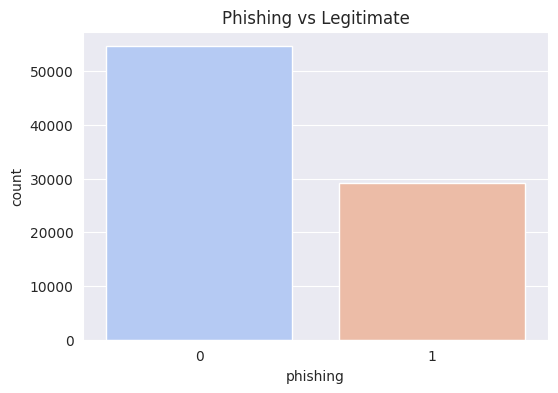

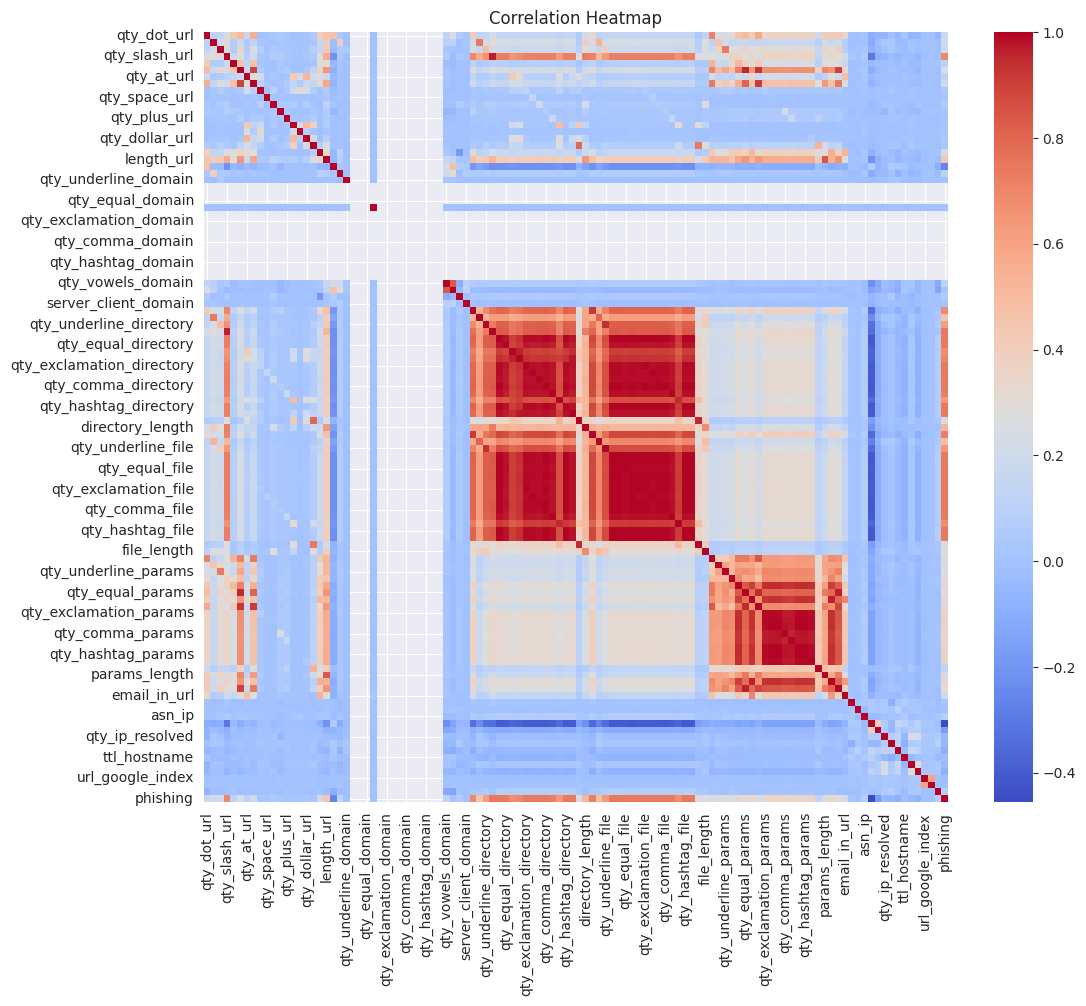

In [ ]:
print(data.describe())

plt.figure(figsize=(6,4))
sns.countplot(x='phishing', data=data, palette='coolwarm')
plt.title("Phishing vs Legitimate")
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

data.hist(figsize=(12,10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


In [ ]:
phishing = data[data['phishing'] == 1]
legitimate = data[data['phishing'] == 0]

legitimate_downsampled = resample(legitimate, replace=False, n_samples=len(phishing), random_state=42)
balanced_data = pd.concat([phishing, legitimate_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset shape:", balanced_data.shape)

X = balanced_data.drop(columns=['phishing'])
y = balanced_data['phishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Reshape input to 3D for LSTM/GRU: (samples, time_steps, features)


print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Balanced dataset shape: (58558, 112)
Training set shape: (46846, 111)
Testing set shape: (11712, 111)


In [ ]:
X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])


In [ ]:
# changes made here
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import get_custom_objects

# Define the custom NeuralFieldAttention layer
class NeuralFieldAttention(Layer):
    def __init__(self, units, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W_q = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.W_k = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.W_v = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.W_out = self.add_weight(shape=(self.units, input_shape[-1]), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        Q = tf.tensordot(inputs, self.W_q, axes=[[2], [0]])
        K = tf.tensordot(inputs, self.W_k, axes=[[2], [0]])
        V = tf.tensordot(inputs, self.W_v, axes=[[2], [0]])

        attention_scores = tf.nn.softmax(tf.matmul(Q, K, transpose_b=True) / tf.sqrt(float(self.units)), axis=-1)
        attention_output = tf.matmul(attention_scores, V)
        output = tf.tensordot(attention_output, self.W_out, axes=[[2], [0]])

        return output + inputs  # Residual connection

    def get_config(self):
        # Include the units as part of the config to be saved
        config = super(NeuralFieldAttention, self).get_config()
        config.update({"units": self.units})
        return config

# Register the custom layer so Keras can use it during model loading
get_custom_objects().update({"NeuralFieldAttention": NeuralFieldAttention})


In [ ]:
# # Custom NeuralFieldAttention Layer
# class NeuralFieldAttention(Layer):
#     def __init__(self, units):
#         super(NeuralFieldAttention, self).__init__()
#         self.units = units

#     def build(self, input_shape):
#         self.W_q = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
#         self.W_k = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
#         self.W_v = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
#         self.W_out = self.add_weight(shape=(self.units, input_shape[-1]), initializer='glorot_uniform', trainable=True)

#     def call(self, inputs):
#         Q = tf.tensordot(inputs, self.W_q, axes=[[2], [0]])
#         K = tf.tensordot(inputs, self.W_k, axes=[[2], [0]])
#         V = tf.tensordot(inputs, self.W_v, axes=[[2], [0]])

#         attention_scores = tf.nn.softmax(tf.matmul(Q, K, transpose_b=True) / tf.sqrt(float(self.units)), axis=-1)
#         attention_output = tf.matmul(attention_scores, V)
#         output = tf.tensordot(attention_output, self.W_out, axes=[[2], [0]])
#         return output + inputs  # Residual connection

# Define model
inputs = Input(shape=(1, X_train.shape[2]))
x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = GRU(32, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = NeuralFieldAttention(units=32)(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_nfa = Model(inputs, outputs)

model_nfa.compile(optimizer=keras.optimizers.Adam(0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

model_nfa.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_nfa = model_nfa.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping],
                            verbose=1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 111)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 64)          │        45,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1, 32)          │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neural_field_attention          │ (None, 1, 32)          │         4,096 │
│ (NeuralFieldAttention)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,737 (237.25 KB)

 Trainable params: 60,737 (237.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - AUC: 0.9494 - Precision: 0.8682 - Recall: 0.9531 - accuracy: 0.9030 - loss: 0.2798 - val_AUC: 0.9765 - val_Precision: 0.9204 - val_Recall: 0.9303 - val_accuracy: 0.9249 - val_loss: 0.1948
Epoch 2/50
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - AUC: 0.9735 - Precision: 0.9013 - Recall: 0.9517 - accuracy: 0.9231 - loss: 0.1996 - val_AUC: 0.9775 - val_Precision: 0.8862 - val_Recall: 0.9672 - val_accuracy: 0.9215 - val_loss: 0.1985
Epoch 3/50
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - AUC: 0.9764 - Precision: 0.9071 - Recall: 0.9510 - accuracy: 0.9264 - loss: 0.1895 - val_AUC: 0.9782 - val_Precision: 0.9285 - val_Recall: 0.9286 - val_accuracy: 0.9285 - val_loss: 0.1885
Epoch 4/50
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - AUC: 0.9771 - Precision: 0.9104 - Recall: 0.9466 - accuracy: 0.9275 - loss: 0.1864 - val_AUC: 0.9785 - val_Precision: 0.9373 - val_Recall: 0.9093 - val_accuracy: 0.9243 - val_loss: 0.1895
Epoch 5/50
1464/1464

In [ ]:
y_pred_nfa = (model_nfa.predict(X_test) > 0.5).astype(int)

accuracy_nfa = accuracy_score(y_test, y_pred_nfa)
precision_nfa = precision_score(y_test, y_pred_nfa)
recall_nfa = recall_score(y_test, y_pred_nfa)
auc_nfa = roc_auc_score(y_test, y_pred_nfa)
conf_matrix_nfa = confusion_matrix(y_test, y_pred_nfa)

print("\nLSTM + GRU with NeuralFieldAttention Evaluation:")
print(f"Accuracy: {accuracy_nfa:.4f}")
print(f"Precision: {precision_nfa:.4f}")
print(f"Recall: {recall_nfa:.4f}")
print(f"AUC Score: {auc_nfa:.4f}")
print("Confusion Matrix:")
print(conf_matrix_nfa)

np.save("model_history_NFA_HYBRID.npy", history_nfa.history)


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

LSTM + GRU with NeuralFieldAttention Evaluation:
Accuracy: 0.9426
Precision: 0.9349
Recall: 0.9515
AUC Score: 0.9426
Confusion Matrix:
[[5468  388]
 [ 284 5572]]


In [ ]:
fp, fn = conf_matrix_nfa[0][1], conf_matrix_nfa[1][0]
tn, tp = conf_matrix_nfa[0][0], conf_matrix_nfa[1][1]

far_nfa = fp / (fp + tn)
frr_nfa = fn / (fn + tp)

print("\nFalse Acceptance Rate (FAR):", round(far_nfa, 4))
print("False Rejection Rate (FRR):", round(frr_nfa, 4))



False Acceptance Rate (FAR): 0.0663
False Rejection Rate (FRR): 0.0485


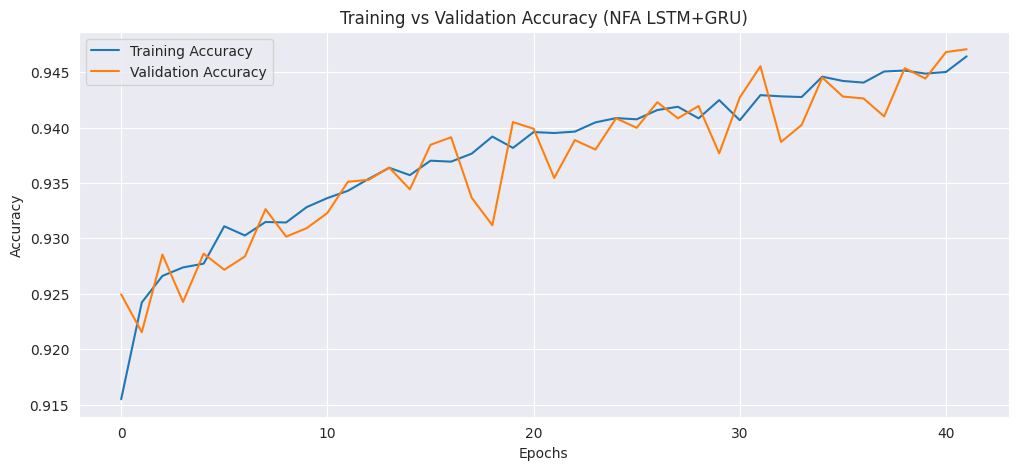

Trained model saved as phishing_detection_LSTMGRU_model.keras


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(history_nfa.history['accuracy'], label='Training Accuracy')
plt.plot(history_nfa.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy (NFA LSTM+GRU)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history_nfa.history['loss'], label='Training Loss')
plt.plot(history_nfa.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss (NFA LSTM+GRU)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model_nfa.save("phishing_detection_LSTMGRU_model.keras")
print("Trained model saved as phishing_detection_LSTMGRU_model.keras")



In [ ]:
print(data.columns.tolist())


['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url', 'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url', 'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url', 'qty_comma_url', 'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url', 'qty_dollar_url', 'qty_percent_url', 'qty_tld_url', 'length_url', 'qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain', 'qty_slash_domain', 'qty_questionmark_domain', 'qty_equal_domain', 'qty_at_domain', 'qty_and_domain', 'qty_exclamation_domain', 'qty_space_domain', 'qty_tilde_domain', 'qty_comma_domain', 'qty_plus_domain', 'qty_asterisk_domain', 'qty_hashtag_domain', 'qty_dollar_domain', 'qty_percent_domain', 'qty_vowels_domain', 'domain_length', 'domain_in_ip', 'server_client_domain', 'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory', 'qty_and_directory', 'qty_exclamation_directory', 'qty_spac

In [ ]:
data.head(2)

qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  qty_exclamation_url  qty_space_url  qty_tilde_url  qty_comma_url  qty_plus_url  qty_asterisk_url  qty_hashtag_url  qty_dollar_url  qty_percent_url  qty_tld_url  length_url  qty_dot_domain  qty_hyphen_domain  qty_underline_domain  qty_slash_domain  qty_questionmark_domain  qty_equal_domain  qty_at_domain  qty_and_domain  qty_exclamation_domain  qty_space_domain  qty_tilde_domain  qty_comma_domain  qty_plus_domain  qty_asterisk_domain  qty_hashtag_domain  qty_dollar_domain  qty_percent_domain  qty_vowels_domain  domain_length  domain_in_ip  server_client_domain  qty_dot_directory  qty_hyphen_directory  qty_underline_directory  qty_slash_directory  qty_questionmark_directory  qty_equal_directory  qty_at_directory  qty_and_directory  qty_exclamation_directory  qty_space_directory  qty_tilde_directory  qty_comma_directory  qty_plus_directory  \
0     0.086957             0.0           0.000000       0.022727                   0.0       0.000000         0.0     0.000000                  0.0            0.0            0.0            0.0           0.0               0.0              0.0             0.0              0.0     0.083333    0.005047        0.095238                0.0                   0.0               0.0                      0.0               0.0            0.0             0.0                     0.0               0.0               0.0               0.0              0.0                  0.0                 0.0                0.0                 0.0           0.065574       0.057269             0                     0                0.1              0.041667                 0.055556             0.086957                         1.0             0.166667          0.022727           0.037037                        0.1                  0.1             0.166667             0.166667                0.05   
1     0.173913             0.0           0.047619       0.068182                   0.0       0.130435         0.0     0.076923                  0.0            0.0            0.0            0.0           0.0               0.0              0.0             0.0              0.0     0.250000    0.052632        0.095238                0.0                   0.0               0.0                      0.0               0.0            0.0             0.0                     0.0               0.0               0.0               0.0              0.0                  0.0                 0.0                0.0                 0.0           0.081967       0.052863             0                     0                0.2              0.041667                 0.055556             0.173913                         1.0             0.166667          0.022727           0.037037                        0.1                  0.1             0.166667             0.166667                0.05   

   qty_asterisk_directory  qty_hashtag_directory  qty_dollar_directory  qty_percent_directory  directory_length  qty_dot_file  qty_hyphen_file  qty_underline_file  qty_slash_file  qty_questionmark_file  qty_equal_file  qty_at_file  qty_and_file  qty_exclamation_file  qty_space_file  qty_tilde_file  qty_comma_file  qty_plus_file  qty_asterisk_file  qty_hashtag_file  qty_dollar_file  qty_percent_file  file_length  qty_dot_params  qty_hyphen_params  qty_underline_params  qty_slash_params  qty_questionmark_params  qty_equal_params  qty_at_params  qty_and_params  qty_exclamation_params  qty_space_params  qty_tilde_params  qty_comma_params  qty_plus_params  qty_asterisk_params  qty_hashtag_params  qty_dollar_params  qty_percent_params  params_length  tld_present_params  qty_params  email_in_url  time_response  domain_spf    asn_ip  time_domain_activation  time_domain_expiration  qty_ip_resolved  qty_nameservers  qty_mx_servers  ttl_hostname  tls_ssl_certificate  qty_redirects  \
0                0.016393                    1.0              0.090909    

In [ ]:
pip install tldextract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
pip install python-whois


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
pip install dnspython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 4.4 MB/s eta 0:00:00


In [ ]:
!ls  # This will list the files in the current directory.


'dataset_full (1).csv'	        phishing_detection_LSTMGRU_model.keras
 model_history_NFA_HYBRID.npy   sample_data
 model_nfa.h5		        scaler_minmax.pkl
 newphishdata.csv	        scaler_standard.pkl


In [ ]:
# Step 1: Load the saved model and scalers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import joblib

# Register the custom NeuralFieldAttention layer before loading the model
get_custom_objects().update({"NeuralFieldAttention": NeuralFieldAttention})

# Load the model
model_nfa = load_model("phishing_detection_LSTMGRU_model.keras")
print("Model loaded successfully.")

# Load the scalers
scaler_standard = joblib.load("scaler_standard.pkl")
scaler_minmax = joblib.load("scaler_minmax.pkl")
print("Scalers loaded successfully.")


Model loaded successfully.
Scalers loaded successfully.


In [ ]:
import re
import socket
import urllib
import requests
import datetime
import numpy as np
import pandas as pd
import tldextract
from urllib.parse import urlparse
import ssl
import whois
import dns.resolver

def count_char(text, char):
    return text.count(char)

def is_ip(address):
    try:
        socket.inet_aton(address)
        return True
    except:
        return False

# def get_spf_record(domain):
#     try:
#         answers = dns.resolver.resolve(domain, 'TXT')
#         for rdata in answers:
#             for txt_string in rdata.strings:
#                 if b"v=spf1" in txt_string:
#                     return 1
#     except Exception as e:
#         print(f"Error fetching SPF record: {e}")
#     return 0
def get_spf_record(domain, retries=3, timeout=5):
    resolver = dns.resolver.Resolver()
    resolver.nameservers = ['8.8.8.8', '8.8.4.4']  # Google's Public DNS
    try:
        # Try multiple times in case of DNS resolution failure
        for attempt in range(retries):
            try:
                answers = resolver.resolve(domain, 'TXT', lifetime=timeout)
                for rdata in answers:
                    for txt_string in rdata.strings:
                        if b"v=spf1" in txt_string:
                            return 1  # SPF record found
                return 0  # SPF record not found
            except (dns.resolver.NoAnswer, dns.resolver.NXDOMAIN, dns.resolver.Timeout) as e:
                # Log the exception and retry
                if attempt < retries - 1:
                    print(f"Retrying DNS lookup for SPF record (Attempt {attempt + 1}/{retries})...")
                    time.sleep(1)  # Sleep before retrying
                else:
                    print(f"Failed to fetch SPF record after {retries} attempts: {e}")
                    return 0  # Return 0 if SPF record cannot be fetched after retries
    except Exception as e:
        print(f"Error in get_spf_record: {e}")
        return 0  # Return 0 in case of an exception


def extract_features_from_url(url):
    try:
        parsed = urlparse(url)
        ext = tldextract.extract(url)

        # Handle cases where there is no valid domain
        if not ext.domain or not ext.suffix:
            raise ValueError("Invalid URL: missing domain or suffix")

        domain = ext.domain + '.' + ext.suffix if ext.suffix else ext.domain
        subdomain = ext.subdomain
        path = parsed.path
        query = parsed.query
        filename = path.split("/")[-1] if path else ""
        suffix = ext.suffix
        tld_list = suffix.split('.') if suffix else []
        qty_tld_url = len(tld_list)

        # Request time and redirects
        try:
            start = datetime.datetime.now()
            response = requests.get(url, timeout=5, allow_redirects=True)
            end = datetime.datetime.now()
            time_response = (end - start).total_seconds()
            qty_redirects = len(response.history)
        except requests.RequestException:
            time_response = -1
            qty_redirects = -1

        # WHOIS info
        try:
            w = whois.whois(domain)
            creation = w.creation_date
            expiration = w.expiration_date
            if isinstance(creation, list): creation = creation[0]
            if isinstance(expiration, list): expiration = expiration[0]
            time_domain_activation = (datetime.datetime.now() - creation).days if creation else -1
            time_domain_expiration = (expiration - datetime.datetime.now()).days if expiration else -1
        except:
            time_domain_activation = -1
            time_domain_expiration = -1

        def count_chars_in(part, charlist):
            return [count_char(part, c) for c in charlist]

        charlist = ['.', '-', '_', '/', '?', '=', '@', '&', '!', ' ', '~', ',', '+', '*', '#', '$', '%']
        url_parts = [url, domain, path, filename, query]
        counts = []
        for part in url_parts:
            counts.extend(count_chars_in(part, charlist))

        vowels = 'aeiou'
        qty_vowels_domain = sum([domain.count(v) for v in vowels])
        length_url = len(url)
        domain_length = len(domain)
        directory_length = len(path)
        file_length = len(filename)
        params_length = len(query)

        domain_in_ip = int(is_ip(domain))
        email_in_url = int(re.search(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,4}', url) is not None)
        tld_present_params = int(ext.suffix in query)

        try:
            dns_resp = dns.resolver.resolve(domain, 'A')
            qty_ip_resolved = len(dns_resp)
        except:
            qty_ip_resolved = 0

        try:
            dns_resp = dns.resolver.resolve(domain, 'NS')
            qty_nameservers = len(dns_resp)
        except:
            qty_nameservers = 0

        try:
            dns_resp = dns.resolver.resolve(domain, 'MX')
            qty_mx_servers = len(dns_resp)
        except:
            qty_mx_servers = 0

        try:
            cert = ssl.get_server_certificate((domain, 443))
            tls_ssl_certificate = 1
        except:
            tls_ssl_certificate = 0

        try:
            txt_ttl = dns.resolver.resolve(domain, 'A')
            ttl_hostname = txt_ttl.rrset.ttl if txt_ttl.rrset else 0
        except:
            ttl_hostname = 0

        server_client_domain = 0
        asn_ip = 0
        url_google_index = 0
        domain_google_index = 0
        domain_spf = get_spf_record(domain)
        url_shortened = int(re.search(r'(bit\.ly|goo\.gl|tinyurl\.com|t\.co|ow\.ly)', url) is not None)

        feature_values = counts + [
            qty_tld_url,
            length_url,
            qty_vowels_domain,
            domain_length,
            domain_in_ip,
            server_client_domain,
            directory_length,
            file_length,
            params_length,
            tld_present_params,
            query.count('&') + 1 if query else 0,
            email_in_url,
            time_response,
            domain_spf,
            asn_ip,
            time_domain_activation,
            time_domain_expiration,
            qty_ip_resolved,
            qty_nameservers,
            qty_mx_servers,
            ttl_hostname,
            tls_ssl_certificate,
            qty_redirects,
            url_google_index,
            domain_google_index,
            url_shortened
        ]

        col_names = ['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url', 'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url', 'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url', 'qty_comma_url', 'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url', 'qty_dollar_url', 'qty_percent_url', 'qty_tld_url', 'length_url', 'qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain', 'qty_slash_domain', 'qty_questionmark_domain', 'qty_equal_domain', 'qty_at_domain', 'qty_and_domain', 'qty_exclamation_domain', 'qty_space_domain', 'qty_tilde_domain', 'qty_comma_domain', 'qty_plus_domain', 'qty_asterisk_domain', 'qty_hashtag_domain', 'qty_dollar_domain', 'qty_percent_domain', 'qty_vowels_domain', 'domain_length', 'domain_in_ip', 'server_client_domain', 'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory', 'qty_and_directory', 'qty_exclamation_directory', 'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory', 'qty_asterisk_directory', 'qty_hashtag_directory', 'qty_dollar_directory', 'qty_percent_directory', 'directory_length', 'qty_dot_file', 'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_and_file', 'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file', 'qty_comma_file', 'qty_plus_file', 'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file', 'qty_percent_file', 'file_length', 'qty_dot_params', 'qty_hyphen_params', 'qty_underline_params', 'qty_slash_params', 'qty_questionmark_params', 'qty_equal_params', 'qty_at_params', 'qty_and_params', 'qty_exclamation_params', 'qty_space_params', 'qty_tilde_params', 'qty_comma_params', 'qty_plus_params', 'qty_asterisk_params', 'qty_hashtag_params', 'qty_dollar_params', 'qty_percent_params', 'params_length', 'tld_present_params', 'qty_params', 'email_in_url', 'time_response', 'domain_spf', 'asn_ip', 'time_domain_activation', 'time_domain_expiration', 'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname', 'tls_ssl_certificate', 'qty_redirects', 'url_google_index', 'domain_google_index', 'url_shortened']

        df = pd.DataFrame([feature_values], columns=col_names)
        return df

    except Exception as e:
        print(f"Error extracting features: {e}")
        return None
0+

In [ ]:
# Step 3: Preprocessing the extracted features
def preprocess_url_features(df):
    """
    Preprocess the extracted features (apply scalers and reshape)
    to match the model's input format.
    """
    # List of boolean columns that should not be scaled
    boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params',
                       'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened']

    # Identify numerical columns
    numerical_columns = [col for col in df.columns if col not in boolean_columns]

    # Apply the scalers (StandardScaler + MinMaxScaler)
    df[numerical_columns] = scaler_standard.transform(df[numerical_columns])
    df[numerical_columns] = scaler_minmax.transform(df[numerical_columns])

    # Reshape the features to match LSTM input format (samples, timesteps, features)
    return df.values.reshape(1, 1, -1)


In [ ]:
# Step 4: URL input (replace this with dynamic user input in a real scenario)
input_url = "https://www.google.com/"  # Replace with dynamic input

# Step 5: Extract features from the URL
extracted_features_df = extract_features_from_url(input_url)
if extracted_features_df is not None:
    # Step 6: Preprocess the extracted features
    preprocessed_data = preprocess_url_features(extracted_features_df)

    # Step 7: Get model prediction
    prediction = model_nfa.predict(preprocessed_data)

    # Step 8: Output the prediction result
    if prediction > 0.5:
        print("Phishing detected!")
    else:
        print("Legitimate URL detected.")
else:
    print("Error extracting features.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Phishing detected!


In [ ]:
# Step 4: Multiple URL input
input_urls = [
    "https://www.amazon.com/",
    "http://www.paypal-support.com/security-update/?email=update",
    "https://secure-verify-login.online/banking/login",
    "https://www.google.com/",
    "http://www.micros0ft.com/verify-your-account",
    "http://www.paypal.com/signin"
]

# Step 5: Loop through each URL
for input_url in input_urls:
    print(f"Processing URL: {input_url}")

    # Extract features from the URL
    extracted_features_df = extract_features_from_url(input_url)
    if extracted_features_df is not None:
        # Step 6: Preprocess the extracted features
        preprocessed_data = preprocess_url_features(extracted_features_df)

        # Step 7: Get model prediction
        prediction = model_nfa.predict(preprocessed_data)

        # Step 8: Output the prediction result
        if prediction > 0.5:
            print(f"URL: {input_url} - Phishing detected!")
        else:
            print(f"URL: {input_url} - Legitimate URL detected.")
    else:
        print(f"Error extracting features for URL: {input_url}")


Processing URL: https://www.amazon.com/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
URL: https://www.amazon.com/ - Legitimate URL detected.
Processing URL: http://www.paypal-support.com/security-update/?email=update
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
URL: http://www.paypal-support.com/security-update/?email=update - Phishing detected!
Processing URL: https://secure-verify-login.online/banking/login
Retrying DNS lookup for SPF record (Attempt 1/3)...
Retrying DNS lookup for SPF record (Attempt 2/3)...
Failed to fetch SPF record after 3 attempts: The DNS query name does not exist: secure-verify-login.online.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
URL: https://secure-verify-login.online/banking/login - Phishing detected!
Processing URL: https://www.google.com/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
URL: https://www.google.com/ - Phishing detected!
Processing URL: http://www.micros0ft.com/verify-your-account
Retrying DNS lookup for SPF record (Attempt 1/3)...
Retrying DNS lookup for SPF recor

In [ ]:
url_to_check = "https://www.youtube.com/"
features_df = extract_features_from_url(url_to_check)

if features_df is not None:
    print(features_df)
else:
    print("Error in feature extraction.")


   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  qty_exclamation_url  qty_space_url  qty_tilde_url  qty_comma_url  qty_plus_url  qty_asterisk_url  qty_hashtag_url  qty_dollar_url  qty_percent_url  qty_tld_url  length_url  qty_dot_domain  qty_hyphen_domain  qty_underline_domain  qty_slash_domain  qty_questionmark_domain  qty_equal_domain  qty_at_domain  qty_and_domain  qty_exclamation_domain  qty_space_domain  qty_tilde_domain  qty_comma_domain  qty_plus_domain  qty_asterisk_domain  qty_hashtag_domain  qty_dollar_domain  qty_percent_domain  qty_vowels_domain  domain_length  domain_in_ip  server_client_domain  qty_dot_directory  qty_hyphen_directory  qty_underline_directory  qty_slash_directory  qty_questionmark_directory  qty_equal_directory  qty_at_directory  qty_and_directory  qty_exclamation_directory  qty_space_directory  qty_tilde_directory  qty_comma_directory  qty_plus_directory  \
0            2      

In [ ]:
print("Confidence (raw model output):", result['confidence'])


NameError: name 'result' is not defined